The computation, algorithm and data collection procedures for this notebook are referenced from
_Building height estimation using Google Earth_ By

Feng Qi, John Z. Zhai , Gaihong Dang


# Module Imports


In [2]:
import math
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

# Computation


In [3]:
# constants

LA2B = 9.25
LA1A2 = 3.16
ALPHA_SA = 128.10  # degrees
ALPHA_S = 145.66  # degrees
LAT = 30.26
DATE = date(2012, 3, 31)


## Solar Declination

##### $$ \delta = 0.3723 + 23.2567 \sin w + 0.1149 \sin 2w - 0.1712 \sin 3w − 0.7580 \cos w + 0.3656 \cos 2w + 0.0201 \cos 3w$$

$$ w = \frac{360(n - n\_{0} - 0.5)}{365.2422} $$
$$ n_0 = 78.801 + 0.2422(YEAR − 1969) − INT(0.25(YEAR − 1969)) w $$


In [4]:
def compute_solar_declination(d):
    n_0 = 78.801 + 0.2422 * (d.year - 1969) - int(0.25 * (d.year - 1969))
    n = (d - date(d.year, 1, 1)).days
    w = 360 * (n - n_0 - 0.5) / 365.2422
    w = math.radians(w)
    delta = (
        0.3723
        + 23.2567 * math.sin(w)
        + 0.1149 * math.sin(2 * w)
        - 0.1712 * math.sin(3 * w)
        - 0.7580 * math.cos(w)
        + 0.3656 * math.cos(2 * w)
        + 0.0201 * math.cos(3 * w)
    )
    return delta


4.032723851690243

## Solar Hour Angle

$$ \Omega =   \left\{
\begin{array}{ll}
      min(\arccos (\frac{-b + \sqrt{b^2 - 4ac}}{2a}),\\ 
            \quad \quad \ \arccos (\frac{-b - \sqrt{b^2 - 4ac}}{2a}) ) \quad in \ the \ morning \\ \\
      -min(\arccos (\frac{-b + \sqrt{b^2 - 4ac}}{2a}),\\ 
            \quad \quad \quad \arccos (\frac{-b - \sqrt{b^2 - 4ac}}{2a}) ) \quad in \ the \ afternoon \\
\end{array} 
\right.  $$

<br>

$$a = \tan ^2 \alpha_{s} \sin^2 \phi + 1$$
$$b = − \sin 2 \phi \tan \delta \tan^2 \alpha_s $$
$$c = \tan^2 \alpha_s \cos^2 \phi tan^2 \delta − 1 $$

In [5]:
def get_solarhourangle(alpha, phi, delta, isMorning=True):
    alpha, phi, delta = math.radians(alpha), math.radians(phi), math.radians(delta)
    a = (math.tan(alpha) ** 2) * (math.sin(phi) ** 2) + 1
    b = -math.sin(2 * phi) * math.tan(delta) * (math.tan(alpha) ** 2)
    c = (math.tan(alpha) ** 2) * (math.cos(phi) ** 2) * (math.tan(delta) ** 2) - 1

    gamma = min(
        math.acos((-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)),
        math.acos((-b - math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)),
    )

    if not isMorning:
        gamma *= -1

    return math.degrees(gamma)


## Solar Elevation

$$ h_s = \arcsin ( \sin \phi \sin \delta + \cos \phi \cos \delta \cos \Omega) $$


In [6]:
def get_solarelevation(phi, delta, omega):
    phi, delta, omega = math.radians(phi), math.radians(delta), math.radians(omega)
    h_s = math.asin(
        math.sin(phi) * math.sin(delta)
        + math.cos(phi) * math.cos(delta) * math.cos(omega)
    )
    return math.degrees(h_s)


59.37535185737855

## $R_{HS}$ and $R_{CS}$


$$ L_{A1A2} =  \sqrt{L_{A1B}^2 + L_{A2B}^2 - 2L_{A1B}L_{A2B} \cos (\alpha_s - \alpha_sA)} $$ 
$$ H = \tan h_s (L_{A2B} \cos (\alpha_{s} - \alpha_{sA}) + \sqrt{L_{A1A2}^2 - L_{A2B}^2 \sin^2 (\alpha_s - \alpha_sA)})$$

$$ R_{HS} = \frac{H}{L_{A2B}} $$
$$ R_{CS} = \frac{H}{L_{A1A2}} $$


In [7]:
def get_La1a2(a2b, a1b, alpha_s, alpha_sa):
    alpha_diff = math.radians(alpha_s - alpha_sa)
    a1a2_square = (a2b ** 2) + (a1b ** 2) - (2 * a1b * a2b * math.cos(alpha_diff))
    return math.sqrt(a1a2_square)


def get_ratios(hs, alpha_s, alpha_sa, la2b, la1a2):
    hs, alpha_diff = math.radians(hs), math.radians(alpha_s - alpha_sa)

    H = math.tan(hs) * (
        la2b * math.cos(alpha_diff)
        + math.sqrt((la1a2 ** 2) - (la1a2 ** 2) * (math.sin(alpha_diff) ** 2))
    )
    return H / la2b, H / la1a2


(2.1607249251222003, 6.324906821955808)

## Height Estimation

$$ H = R_{HS}L_{A2B} $$
$$ H = R_{CS}L_{A1B1} $$


In [8]:
def estimate_height(length, ratio):
    return length * ratio


actual_height = [
    19.56,
    18.13,
    16.25,
    18.52,
    19.24,
    18.69,
    19.48,
    18.45,
    14.91,
    14.08,
    14.94,
    15.21,
    12.94,
    14.07,
    13.64,
    15.40,
    16.37,
]

heights = [
    9.01,
    9.25,
    9.13,
    9.15,
    9.46,
    9.82,
    9.61,
    9.24,
    7.37,
    7.16,
    7.24,
    7.73,
    6.09,
    6.59,
    6.56,
    7.78,
    7.87,
]

error = []
estimations = []
for h, y in zip(heights, actual_height):
    h = round(estimate_height(h, rhs), 2)
    estimations.append(h)
    error.append(h - y)

print("Estimated Heights:", estimations)
print("Actual Heights:   ", actual_height)

print("Mean absolute error:", sum([abs(x) for x in error]) / len(error))


Estimated Heights: [19.47, 19.99, 19.73, 19.77, 20.44, 21.22, 20.76, 19.97, 15.92, 15.47, 15.64, 16.7, 13.16, 14.24, 14.17, 16.81, 17.0]
Actual Heights:    [19.56, 18.13, 16.25, 18.52, 19.24, 18.69, 19.48, 18.45, 14.91, 14.08, 14.94, 15.21, 12.94, 14.07, 13.64, 15.4, 16.37]
Mean absolute error: 1.2211764705882353


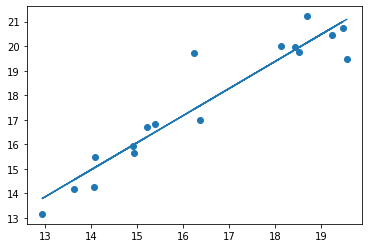

In [22]:
best_fit = np.polyfit(actual_height, estimations, 1)
best_fit
best_fit[0] * np.array(actual_height) + best_fit[1]
plt.scatter(actual_height, estimations)
plt.plot(actual_height, best_fit[0] * np.array(actual_height) + best_fit[1])
plt.show()
